In [10]:
from pathlib import Path
import xarray as xr
import warnings

from pyorg.core.geometry import get_cells_area

import pycompo.coord as pccoord
import pycompo.ellipse as pcellipse
import pycompo.feature_cutout as pcfeatcut
import pycompo.filter as pcfilter
import pycompo.plot as pcplot
import pycompo.sst_features as pcsst
import pycompo.wind as pcwind

from pycompo.composite import interpolate2compo_coords
from pycompo.utils import read_yaml_config

warnings.filterwarnings(action='ignore')

# read in configuration file
config_file = "/home/m/m300738/libs/pycompo/config/settings_template.yaml"
config = read_yaml_config(config_file)

start_time = config['data']['analysis_time'][0]
end_time = config['data']['analysis_time'][1]

### Read in data

In [ ]:
varlst = [config['data']['feature_var']] + config['data']['wind_vars']

infiles = []
for var in varlst:
    inpath = Path(config['data']['inpaths'][var])
    in_pattern = \
        f"{config['exp']}_tropical_{var}_20200801T000000Z-20200901T000000Z.nc"
    infiles.extend(sorted([str(f) for f in inpath.rglob(in_pattern)]))
dset = xr.open_mfdataset(infiles, parallel=True).squeeze()
dset = dset.isel(time=slice(0, 2))
for var in config['data']['wind_vars']: dset[var] = dset[var].compute()
dset['cell_area'] = get_cells_area(dset)

### Building SST anomalies using Gaussian filter

In [3]:
# Gaussian filter to extract anomalies
dset = xr.merge([
    dset,
    pcfilter.get_gaussian_filter_bg_ano(
        dset[config['data']['feature_var']], **config['filter'],
        )
    ])
dset = dset.sel(lat=slice(*config['lat_range']), drop=True)
orig_coords = pccoord.get_coords_orig(dset)

### Detection of SST clusters and cutout of corresponding data

In [4]:
feature_var = config['data']['feature_var']

dset[f"{feature_var}_feature"], feature_props = \
    pcsst.extract_sst_features(dset[f"{feature_var}_ano"], **config['feature'])
dset, feature_props, feature_data = pcfeatcut.get_featcen_data_cutouts(
    dset, feature_props, feature_var, config['cutout']['search_RadRatio'],
    )

feature_ellipse = pcellipse.get_ellipse_params(feature_props, orig_coords)

feature_props = pcwind.calc_feature_bg_wind(
    feature_props, feature_data, config['data']['wind_vars'],
    )
feature_data = pccoord.add_featcen_coords(
    orig_coords, feature_data, feature_props, feature_ellipse,
    )

### Visualization of the SST clusters

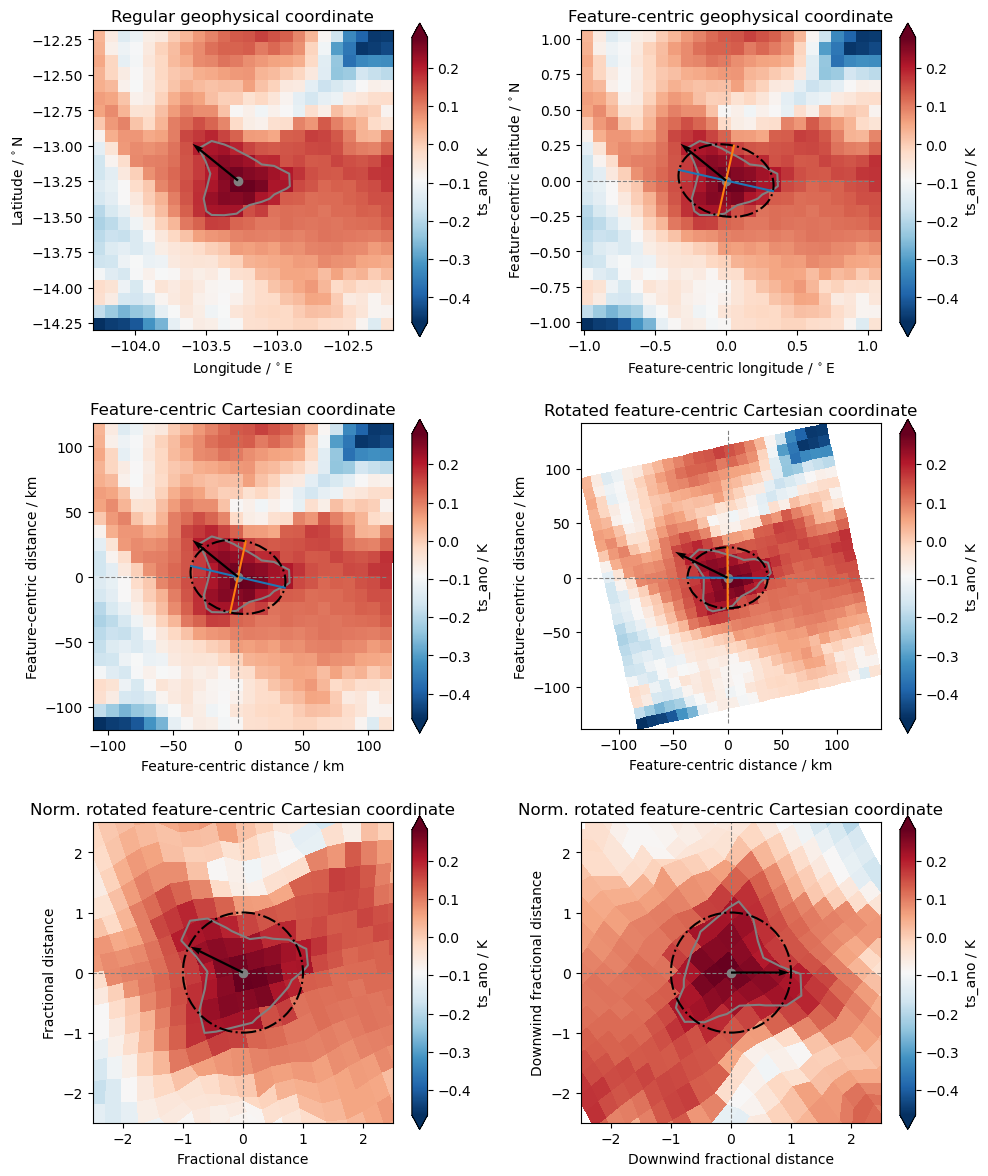

In [ ]:
feature_id = 1
wind = feature_props[['bg_uas', 'bg_vas']]
pcplot.plot_coord_trafo(
    feature_data, feature_ellipse, wind, feature_id,
    f"{config['data']['feature_var']}_ano", config['feature']['threshold'],
    )

### Save data

In [ ]:
analysis_identifier = f"{config['exp']}_{config['pycompo_name']}"

# save feature props
outpath = Path(f"{config['data']['outpath']}/{analysis_identifier}/")
outpath.mkdir(parents=True, exist_ok=True)
outfile = Path(
    f"{analysis_identifier}_feature_props_{start_time}-{end_time}.nc"
    )
feature_props.attrs["identifier"] = analysis_identifier
feature_props.to_netcdf(str(outpath/outfile))

# save feature data
outpath = Path(
    f"{config['data']['outpath']}/{analysis_identifier}/" + \
    f"{analysis_identifier}_feature_data_{start_time}-{end_time}/"
    )
outpath.mkdir(parents=True, exist_ok=True)

for data in feature_data[:3]:
    feature_id = data['feature_id'].values
    outfile = Path(
        f"{analysis_identifier}_feature_data_{start_time}-{end_time}_" + \
        f"feature{feature_id}.nc"
        )
    data.attrs["identifier"] = analysis_identifier
    data.drop(['height_2', 'uas', 'vas']).to_netcdf(str(outpath/outfile))

### Create composite

In [13]:
compo_varlst = [
    f"{config['data']['feature_var']}_ano", "pr_ano", "prw_ano", "hfls_ano",
    "hfss_ano", "sfcwind_ano",
    ]
feature_compo_data = {
    var: interpolate2compo_coords(
        feature_data,
        (config['composite']['compo_x'], config['composite']['compo_y']),
        var
        ) for var in compo_varlst
    }
feature_compo_data = xr.merge([feature_compo_data[var] for var in compo_varlst])

KeyError: 'pr_ano'

In [14]:
import importlib as implib
implib.reload(pcplot)

for var in compo_varlst:
    pcplot.plot_composite(feature_compo_data[var])

NameError: name 'feature_compo_data' is not defined